In [1]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

In [4]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

count_m = 0

for idx_m, m in enumerate(list(dic_ssp585.keys())):
    if (len(dic_ssp585[m].keys()) > 2) and (count_m < 15):
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]
        count_m +=1

In [5]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        # for t in enumerate(range(time_period)[:2]):
            # print(np.where(np.isnan(dic_reduced_ssp585[m][i][t,:,:].ravel())==True))
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        # nan_idx_tmp_tt = list(np.where(np.isnan(dic_reduced_ssp585[m][i][1,:,:].ravel())==True)[0])
        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

In [6]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble

/tmp/ipykernel_30975/2788081108.py:17: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_30975/2788081108.py:19: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [7]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

In [8]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

In [9]:
import torch 

# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    # variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)
    variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)

In [10]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train[m][i] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)

In [12]:
def ridge_estimator(model_out,x,y,vars,lambda_):
    """
    Compute the ridge estimator given gammas.
    """
    idx_start = 0
    for idx_m,m in enumerate(list(x.keys())):
        if m!= model_out:
            if idx_start==0:
                X_tmp = x[m]
                y_tmp = y[m]
                D = (1/vars[m])*torch.eye(x[m].shape[0])
                idx_start +=1
            else:
                X_tmp = torch.cat((X_tmp,x[m]),0)
                y_tmp = torch.cat((y_tmp,y[m]),0)
                D_tmp = ((1/vars[m]) * torch.eye(x[m].shape[0])).to(torch.float64)
                D = torch.block_diag(D, D_tmp).to(torch.float64)

    A = torch.matmul(torch.matmul(X_tmp.T, D),X_tmp) + lambda_ * torch.eye(X_tmp.shape[1])
    b = torch.matmul(torch.matmul(X_tmp.T,D),y_tmp)
    
    return torch.linalg.solve(A,b)

In [13]:
def train_ridge_regression(x,y,vars,lon_size,lat_size,models,lambda_,nbEpochs=100,verbose=True):
    """
    Given a model m, learn parameter β^m such that β^m = argmin_{β}(||y_m - X_m^T β||^2) ).

    Args:
        - x, y: training set and training target 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - lambda_: regularizer coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lat_size*lon_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-4)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0

    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
        
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        res = torch.zeros(len(models),33)

        
        for idx_m, m in enumerate(models):

            for idx_i, i in enumerate(x[m].keys()):
               
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i][:,notnan_idx],beta[notnan_idx]))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/len(x[m].keys())

        obj = torch.mean(res)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        if epoch < nbEpochs:
            training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch, 
                    ', loss=', loss.detach().item()
                    )

        criteria = loss
        epoch +=1
        

    # plt.figure()
    # plt.plot(range(nbEpochs)[:epoch],training_loss[:epoch])
    # plt.title('Training loss')
    # plt.ylabel('Loss')
    # plt.xlabel('iterations')
    # plt.show()
    return beta.detach().clone()

In [14]:
def train_robust_model(x,y,vars,lon_size,lat_size,models,lambda_,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    # beta = torch.ones(lon_size*lat_size).to(torch.float64)
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-4)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    # while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):
    while (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
        res = torch.zeros(len(models),33)

        for idx_m, m in enumerate(models):            
            for idx_i, i in enumerate(x[m].keys()):
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i][:,notnan_idx],beta[notnan_idx]))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/(len(x[m].keys()))

        obj = mu_*torch.logsumexp((1/mu_)* torch.mean(res,axis=1),0)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()              

        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    # plt.figure()
    # plt.plot(range(nbEpochs),training_loss)
    # plt.title('Training loss')
    # plt.ylabel('Loss')
    # plt.xlabel('iterations')
    # plt.show()

    # compute the alphas of the robust model
    M = len(x.keys())
    alpha = torch.zeros(M)
    res = torch.zeros(M,33)
    
    # compute the training loss for each model
    model_loss = torch.zeros(M)
    
    for idx_m,m in enumerate(x.keys()):
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
        model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    alpha = torch.nn.functional.softmax(alpha)
    
    return beta, alpha, model_loss

In [15]:
# Consider a model where we split the set of runs into two datasets

In [25]:
m = 'C'

array([88, 53])

In [43]:
np.random.seed(0)

def split_runs_of_a_model(x,y,m,p):
    """
    Split a model into two models m1 and m2 containgin run proportions p1 and p2.

    Args:
            - m: String
                Model name 
            - p: Scalar in (0,1)
                proportion of runs in the new model. 
    """
    # create the new directory 
    x_tmp = {m+'_1': {}, m+'_2': {}}
    y_tmp = {m+'_1': {}, m+'_2': {}}

    nb_runs = int(np.floor(p*len(x[m].keys())))

    idx_runs = np.random.randint(0,len(x[m].keys()),nb_runs)
    
    # get the number of runs
    for idx_r, r in enumerate(x[m].keys()):

        
        if idx_r in idx_runs:
            x_tmp[m+'_1'][r] = x[m][r]
            y_tmp[m+'_1'][r] = y[m][r]
        else:
            x_tmp[m+'_2'][r] = x[m][r]
            y_tmp[m+'_2'][r] = y[m][r]

    return x_tmp, y_tmp

In [44]:
def compute_variance(x,y):
    
    # compute the variance
    vars = {}

    for idx_m,m in enumerate(x.keys()):
        variance_processed_ssp585[m] = {}
        arr_tmp = np.zeros((len(x[m].keys()),33))
        
        for idx_i, i in enumerate(list(x[m].keys())):
            arr_tmp[idx_i,:] = np.nanmean(x[m][i],axis=1)
    
        arr_tmp_values = np.zeros((len(x[m].keys()),33))
        for idx_i, i in enumerate(x[m].keys()):
            arr_tmp_values[idx_i,:] = (y[m][i] - arr_tmp[idx_i,:])**2
    
        vars[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)

    return vars

In [64]:
m = 'CanESM5-1'
p = 0.2

x_tmp, y_tmp = split_runs_of_a_model(x_train,y_train,m,p)
vars_tmp = compute_variance(x_tmp,y_tmp)

mu_ = 1.0
lambda_ = 100.0
selected_models = [m+'_1', m+'_2']

beta_robust, alpha_robust, model_loss = train_robust_model(x_tmp,y_tmp,vars_tmp,\
                                      lat_size,lon_size,\
                                      selected_models,\
                                      lambda_,mu_,nbEpochs=200,verbose=True)


beta_ridge = train_ridge_regression(x_tmp,y_tmp,vars_tmp,\
                                    lat_size,lon_size,\
                                    selected_models,\
                                    lambda_,nbEpochs=100,verbose=True)

Epoch  0 , loss= 5.383882522583008
Epoch  10 , loss= 1.6764737367630005
Epoch  20 , loss= 1.1184693574905396
Epoch  30 , loss= 1.081565260887146
Epoch  40 , loss= 1.0408475399017334
Epoch  50 , loss= 1.0021604299545288
Epoch  60 , loss= 0.9881739616394043
Epoch  70 , loss= 0.9810740947723389
Epoch  80 , loss= 0.9768920540809631
Epoch  90 , loss= 0.973701000213623
Epoch  100 , loss= 0.9712786674499512
Epoch  110 , loss= 0.9694132804870605
Epoch  120 , loss= 0.9679360389709473
Epoch  130 , loss= 0.9667529463768005
Epoch  140 , loss= 0.9657943248748779
Epoch  150 , loss= 0.9650078415870667
Epoch  160 , loss= 0.9643573760986328
Epoch  170 , loss= 0.9638157486915588
Epoch  180 , loss= 0.963362455368042
Epoch  190 , loss= 0.9629812240600586


/tmp/ipykernel_30975/24363189.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


Epoch  0 , loss= 4.644281387329102
Epoch  10 , loss= 0.9784185886383057
Epoch  20 , loss= 0.4242410361766815
Epoch  30 , loss= 0.38319501280784607
Epoch  40 , loss= 0.34546419978141785
Epoch  50 , loss= 0.30684876441955566
Epoch  60 , loss= 0.29248663783073425
Epoch  70 , loss= 0.2851736545562744
Epoch  80 , loss= 0.28103044629096985
Epoch  90 , loss= 0.27796196937561035


/tmp/ipykernel_30975/4111049071.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


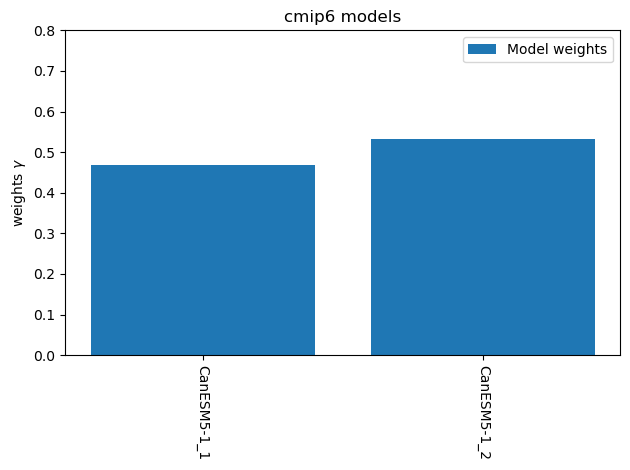

In [65]:
M = len(list(x_tmp.keys()))
gamma = torch.zeros(M)
res = torch.zeros(M,33)

for idx_m,m in enumerate(x_tmp.keys()):
    
    for idx_i, i in enumerate(x_tmp[m].keys()):
        res[idx_m,:] += (y_tmp[m][i] - torch.matmul(x_tmp[m][i],beta_robust))**2/vars_tmp[m]
        
    res[idx_m,:] = res[idx_m,:]/len(x_tmp[m].keys())

    gamma[idx_m] = (1/mu_)*torch.nanmean(res[idx_m,:],axis=0)


gamma = torch.nn.functional.softmax(gamma,dim=0)


# plot the model contributions
fig, ax = plt.subplots()
models = list(x_tmp.keys())
weights = list(gamma.detach().numpy())

ax.bar(models, weights,label='Model weights')
ax.set_ylabel(r'weights $\gamma$')
ax.set_ylim(0.0,0.8)
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
plt.show()

In [63]:
for idx_m,m in enumerate(x_tmp.keys()):
    print(m, len(x_tmp[m].keys()), weights[idx_m])

CanESM5-1_1 3 0.0
CanESM5-1_2 15 1.0
